In [203]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys  # Импортируем Keys
from selenium.webdriver.common.action_chains import ActionChains
import time
driver = webdriver.Safari() 
driver.get("https://www.avito.ru/moskva/rabota") 


In [204]:
element = driver.find_element(By.ID, "bx_search") 

element.send_keys('Уборщик ') 
element.send_keys('в кафе') 
# Разбил на 2 строки, так как очень часто все сливалось в "Уборщиквкафе"

element.send_keys(Keys.ENTER)

In [205]:
button = driver.find_element(By.CSS_SELECTOR, "a[data-marker='category[1000061]/clickable']")
button.click()

In [206]:
vacancies = []  
wage = None
shift = None

for i in range(20):
    elements = driver.find_elements(By.CSS_SELECTOR, 'div[data-marker="item"]')

    for elem in elements:
        try:
          title = elem.find_element(By.CSS_SELECTOR, 'h3[itemprop="name"]').text
          if ('борщи' in title or 'лин' in title) and ('офе' in title or 'афе' in title or 'естора' in title): # берем только вакансии, в которых есть слово "бариста"

             wage_block = elem.find_element(By.CSS_SELECTOR, 'p[data-marker="item-price"]')
             wage = wage_block.find_element(By.CSS_SELECTOR, 'span').text

            # Приводим цену в нормальный вид
             wage = wage.replace("\xa0", " ").strip()
             wage = wage.replace('₽', '').strip()
             wage = wage.replace('от', '').strip()
             wage = wage.replace('до', '').strip()

             if 'на руки' in wage or "до налогов" in wage:
                 after_taxes = True
             if 'сдельно' in wage or 'за смену' in wage:
                 shift = True

             wage = wage.replace('сдельно', '').strip() # С этими случаями нужно еще поработать
             wage = wage.replace('за смену', '').strip()
             wage = wage.replace('на руки', '').strip()
              
             # Работаем со случаем, когда цена представлена диапазоном, а не числом
             if '—' in wage:
                w_min, w_max = wage.split('—')
                w_min = int(w_min.replace(' ', ''))
                w_max = int(w_max.replace(' ', ''))
                wage = (w_min + w_max) // 2  # Берем среднее, если з/п указана диапазоном
             else:
                wage = int(wage.replace(' ', ''))  # Убираем пробелы и превращаем в число
                 
             if shift or '—' in title or 'ойщица' in title:
                pass
             elif after_taxes:
                wage = int(wage / 0.87)              
                vacancies.append([title, wage])
             else:
                vacancies.append([title, wage])

             wage = None
             shift = None
              
        except Exception as e: 
          pass
 
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN) 
    time.sleep(0.75)  

driver.quit()

for item in vacancies:
    print(item)

['Уборщица-в ресторан', 114942]
['Уборщица(к в ресторан м. Преображенская площадь', 109310]
["Уборщик в ресторан Rostic's (ночные смены)", 114942]
['Уборщик в ресторан\\ 4.200 за смену\\ смена 12ч', 134442]
['Уборщик в ресторан', 104597]
['Уборщица в ресторан', 97701]
['Уборщица/Уборщик в кафе', 109195]
['Уборщик/уборщица в ресторан (м. Смоленская)', 103448]
['Уборщик в ресторан\\ 4.200 за смену\\ смена 12ч', 134442]
['Уборщица-в ресторан', 114942]
['Уборщик/уборщица в ресторан (м. Домодедовская)', 104597]
['Уборщик/Уборщица в ресторан', 106896]
['Уборщик в ресторан', 74712]
['Уборщик в кафе', 137931]
['Уборщица / Уборщик в ресторан', 68965]
['Уборщик/ца в кафе платим каждый день', 77011]
['Уборщица в ресторан (еженедельная выплата )', 41954]
['Уборщик/Уборщица в ресторан', 106896]
['Уборщица-в ресторан', 114942]
['Уборщица(к в ресторан м. Преображенская площадь', 109310]
["Уборщик в ресторан Rostic's (ночные смены)", 114942]
['Уборщик в ресторан\\ 4.200 за смену\\ смена 12ч', 134442]


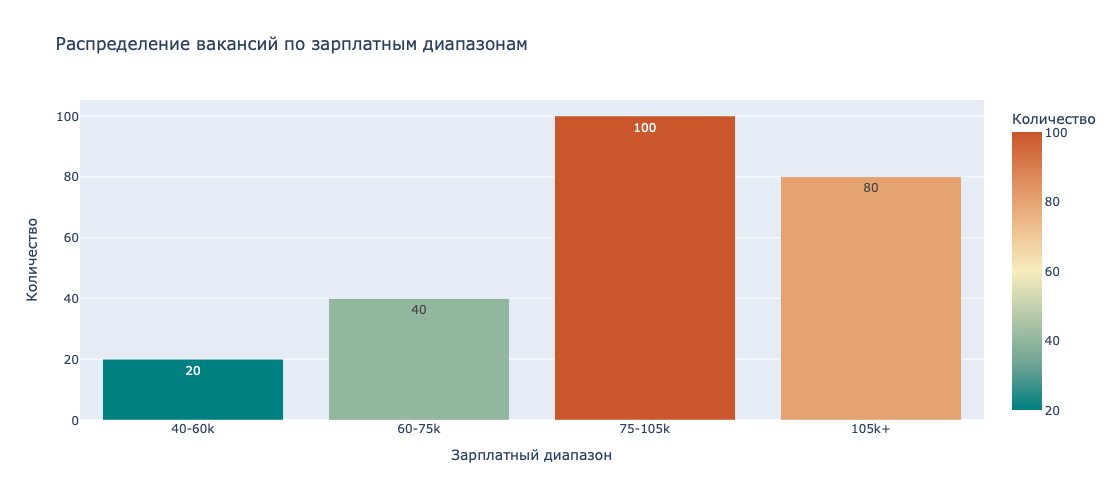

,Вакансия,Зарплата,Диапазон зарплат
0,Уборщица-в ресторан,114942,NaN
1,Уборщица(к в ресторан м. Преображенская площадь,109310,105k+
2,Уборщик в ресторан Rostic's (ночные смены),114942,NaN
4,Уборщик в ресторан,104597,75-105k
5,Уборщица в ресторан,97701,75-105k
...,...,...,...
354,Уборщик в ресторан,74712,60-75k
356,Уборщица / Уборщик в ресторан,68965,60-75k
357,Уборщик/ца в кафе платим каждый день,77011,75-105k
358,Уборщица в ресторан (еженедельная выплата ),41954,40-60k


In [217]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame(vacancies, columns=["Вакансия", "Зарплата"])
df = df[(df["Зарплата"] >= 40000) & (df["Зарплата"] <= 120000)]

# Определяем диапазоны зарплат
bins = [40000, 60000, 75000, 105000, 110000]
labels = ["40-60k", "60-75k", "75-105k", '105k+']
df["Диапазон зарплат"] = pd.cut(df["Зарплата"], bins=bins, labels=labels)

# Группируем по диапазонам и считаем количество вакансий в каждом
df_grouped = df["Диапазон зарплат"].value_counts().reset_index()
df_grouped.columns = ["Диапазон зарплат", "Количество вакансий"]
df_grouped = df_grouped.sort_values("Диапазон зарплат")

# Строим столбчатую диаграмму с Plotly
fig = px.bar(
    df_grouped,
    x="Диапазон зарплат",
    y="Количество вакансий",
    title="Распределение вакансий по зарплатным диапазонам",
    labels={"Количество вакансий": "Количество", "Диапазон зарплат": "Зарплатный диапазон"},
    color="Количество вакансий",
    color_continuous_scale="geyser",
    text_auto=True
)

fig.update_layout(height=500)
fig.show()
display(df)